In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

In [2]:
nside = 256

In [3]:
# a) Read and apodize mask
mask_path = "/home/ketchup/tools/NaMaster/test/"
mask = nmt.mask_apodization(hp.read_map(mask_path + "mask.fits", verbose=False),
                            1., apotype="Smooth")

In [4]:
# Let's now create a fictitious theoretical power spectrum to generate
# Gaussian realizations:
larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.

In [5]:
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr

In [6]:
# This routine generates a spin-0 and a spin-2 Gaussian random field based
# on these power spectra
def get_sample_field():
    mp_t, mp_q, mp_u = hp.synfast([cl_tt, cl_ee, cl_bb, cl_te],
                                  nside, verbose=False)
    return nmt.NmtField(mask, [mp_t]), nmt.NmtField(mask, [mp_q, mp_u])


# We also copy this function from sample_workspaces.py. It computes
# power spectra given a pair of fields and a workspace.
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled

In [7]:
# Let's generate one particular sample and its power spectrum.
print("Field")
f0, f2 = get_sample_field()

Field


In [10]:
# We will use 20 multipoles per bandpower.
b = nmt.NmtBin.from_nside_linear(nside, 20)
print("Workspace")
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f0, f0, b)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2, f2, b)
cl_00 = compute_master(f0, f0, w00)
cl_02 = compute_master(f0, f2, w02)
cl_22 = compute_master(f2, f2, w22)
n_ell = len(cl_00[0])

Workspace


In [11]:
# Let's now compute the Gaussian estimate of the covariance!
print("Covariance")
# First we generate a NmtCovarianceWorkspace object to precompute
# and store the necessary coupling coefficients
cw = nmt.NmtCovarianceWorkspace()
# This is the time-consuming operation
# Note that you only need to do this once,
# regardless of spin
cw.compute_coupling_coefficients(f0, f0, f0, f0)

Covariance


In [40]:
cw.wsp.lmax

767

In [39]:
covar_00_00 = nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      w00, wb=w00).reshape([n_ell, 1,
                                                            n_ell, 1])

covar_TT_TT = covar_00_00[:, 0, :, 0]
covar_02_02 = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # ET, BT
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w02).reshape([n_ell, 2,
                                                            n_ell, 2])
covar_TE_TE = covar_02_02[:, 0, :, 0]
covar_TE_TB = covar_02_02[:, 0, :, 1]
covar_TB_TE = covar_02_02[:, 1, :, 0]
covar_TB_TB = covar_02_02[:, 1, :, 1]

covar_00_22 = nmt.gaussian_covariance(cw, 0, 0, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      w00, wb=w22).reshape([n_ell, 1,
                                                            n_ell, 4])
covar_TT_EE = covar_00_22[:, 0, :, 0]
covar_TT_EB = covar_00_22[:, 0, :, 1]
covar_TT_BE = covar_00_22[:, 0, :, 2]
covar_TT_BB = covar_00_22[:, 0, :, 3]

covar_02_22 = nmt.gaussian_covariance(cw, 0, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w22).reshape([n_ell, 2,
                                                            n_ell, 4])
covar_TE_EE = covar_02_22[:, 0, :, 0]
covar_TE_EB = covar_02_22[:, 0, :, 1]
covar_TE_BE = covar_02_22[:, 0, :, 2]
covar_TE_BB = covar_02_22[:, 0, :, 3]
covar_TB_EE = covar_02_22[:, 1, :, 0]
covar_TB_EB = covar_02_22[:, 1, :, 1]
covar_TB_BE = covar_02_22[:, 1, :, 2]
covar_TB_BB = covar_02_22[:, 1, :, 3]

covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22).reshape([n_ell, 4,
                                                            n_ell, 4])
covar_EE_EE = covar_22_22[:, 0, :, 0]
covar_EE_EB = covar_22_22[:, 0, :, 1]
covar_EE_BE = covar_22_22[:, 0, :, 2]
covar_EE_BB = covar_22_22[:, 0, :, 3]
covar_EB_EE = covar_22_22[:, 1, :, 0]
covar_EB_EB = covar_22_22[:, 1, :, 1]
covar_EB_BE = covar_22_22[:, 1, :, 2]
covar_EB_BB = covar_22_22[:, 1, :, 3]
covar_BE_EE = covar_22_22[:, 2, :, 0]
covar_BE_EB = covar_22_22[:, 2, :, 1]
covar_BE_BE = covar_22_22[:, 2, :, 2]
covar_BE_BB = covar_22_22[:, 2, :, 3]
covar_BB_EE = covar_22_22[:, 3, :, 0]
covar_BB_EB = covar_22_22[:, 3, :, 1]
covar_BB_BE = covar_22_22[:, 3, :, 2]
covar_BB_BB = covar_22_22[:, 3, :, 3]

In [31]:
?nmt.gaussian_covariance

Sample covariance
0


1


2


3


4


5


6


7


8


9


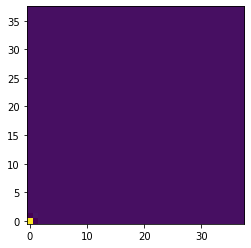

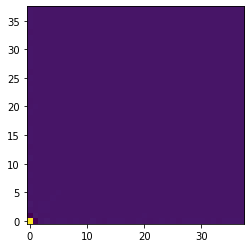

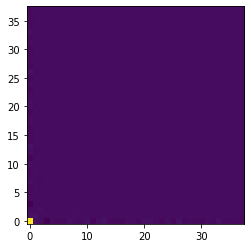

In [29]:
# Let's now compute the sample covariance
# (we'll only do this for spin-0 for simplicity
print("Sample covariance")
nsamp = 10
covar_sample = np.zeros([n_ell, n_ell])
mean_sample = np.zeros(n_ell)
for i in np.arange(nsamp):
    print(i)
    f, _ = get_sample_field()
    cl = compute_master(f, f, w00)[0]
    covar_sample += cl[None, :]*cl[:, None]
    mean_sample += cl
mean_sample /= nsamp
covar_sample = covar_sample / nsamp
covar_sample -= mean_sample[None, :] * mean_sample[:, None]

# Let's plot them:
plt.figure()
plt.imshow(covar_TT_TT, origin='lower', interpolation='nearest')
plt.figure()
plt.imshow(covar_sample, origin='lower', interpolation='nearest')
plt.figure()
plt.imshow(covar_TT_TT-covar_sample, origin='lower', interpolation='nearest')
plt.show()

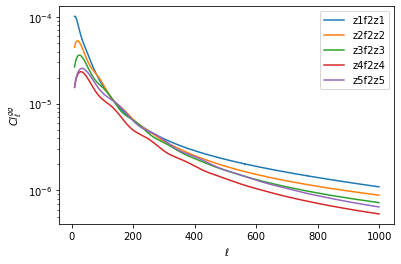

In [56]:
# plot galaxy x galaxy ps in the same redshift bins, linear galaxy scale
maps = ['gg']
zs_bins = ['z1f2z1', 'z2f2z2', 'z3f2z3', 'z4f2z4', 'z5f2z5']
for map in maps:
    for zs_bin in zs_bins:
        Cl_name = 'Cl'+'gg'+'_input_'+'%s.dat' %zs_bin
        # print(Cl_name)
        Cl = np.loadtxt(G_ps_path + Cl_name)
        plt.plot(Cl[ellmin:ellmax,0], Cl[ellmin:ellmax,1], label=zs_bin)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cl^{gg}_{\ell}$')
plt.yscale('log')